## About
This notebook is used to compute the best aligned rosetta pose from TM output.<br/>
Sometimes, atom-names do not match/are shuffled in the final output. This notebook uses mdtraj to sort them out as well as compute the RMSD.<br/> The final output RMSD is in Angstroms<br/>

This pose can later be used for other analyses

**Note:** Some parts of this code may be sensitive to the RNA chosen. These regions are marked out with a <i>'#TODO: Change accordingly'</i> tag

In [1]:
import MDAnalysis as mda
from MDAnalysis.analysis import align
import os
import mdtraj as md
%run ../PyRosetta/General.ipynb

/home/venkata/micromamba/thermomaps/lib/python3.10/site-packages/Bio/Application/__init__.py:40: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


┌──────────────────────────────────────────────────────────────────────────────┐
│                                 PyRosetta-4                                  │
│              Created in JHU by Sergey Lyskov and PyRosetta Team              │
│              (C) Copyright Rosetta Commons Member Institutions               │
│                                                                              │
│ NOTE: USE OF PyRosetta FOR COMMERCIAL PURPOSES REQUIRE PURCHASE OF A LICENSE │
│              See LICENSE.md or email license@uw.edu for details              │
└──────────────────────────────────────────────────────────────────────────────┘
PyRosetta-4 2024 [Rosetta PyRosetta4.Release.python310.linux 2024.08+release.717d2e8232174371f0c672564f23a097062db88a 2024-02-21T10:16:44] retrieved from: http://www.pyrosetta.org


In [2]:
ROOT_DIR="/home/venkata/python/PyRosetta/R1107/server/example9/" #TODO: Change Accordingly
ref_pose_file=ROOT_DIR+"../../7qr4_clean_noprotein.pdb" #TODO: Change Accordingly (Set it to the path of your crystal PDB)
ref_pose=LoadedPDB(ref_pose_file) 
print("Rosetta folder found:",("rosetta" in os.listdir(ROOT_DIR)))

Rosetta folder found: True


In [4]:
# Find all cluster XTC files
clusters=sorted([f for f in os.listdir(ROOT_DIR+"/rosetta/xtc") if (f.endswith(".xtc") and f.startswith("cluster"))])

ref_frame=md.load(ref_pose_file)
ref_frame.restrict_atoms(ref_frame.topology.select("!element H")[1:]) # TODO: Change accordingly (Identify which atoms in reference frame are not in the trajectory. You still need to identify these manually, but shouldn't be too many atoms (usually just capping))

resolved_rmsds=[]
min_rmsd=1e6 # Very large value
min_pose=None
for cl in clusters:
    all_frames=md.load(ROOT_DIR+"/rosetta/xtc/"+cl,top=ROOT_DIR+"/rosetta/xtc/top.pdb")

    # Pick and sort all the heavy atoms into one specific order
    ref_names=np.array([str(ref_frame.topology.atom(i)).strip() for i in range(ref_frame.xyz.shape[1])],dtype=str)
    s1=np.argsort(ref_names)

    ref_xyz=ref_frame.xyz[0][s1]
    for i in range(len(all_frames)):
        frame=all_frames[i]
        frame.restrict_atoms(frame.topology.select("!element H")) # Pick heavy atoms

        # Sort all heavy atoms in the same way we did the reference frame
        frame_names=np.array([str(frame.topology.atom(i)).strip() for i in range(frame.xyz.shape[1])],dtype=str)
        s2=np.argsort(frame_names)

        # Check that all atom-names match 1-1 before aligning
        assert(np.sum(frame_names[s2]==ref_names[s1])==len(ref_names))

        # Get XYZ, align and compute RMSD
        frame_xyz=frame.xyz[0][s2]
        rms_val=align.rms.rmsd(ref_xyz,frame_xyz,superposition=True)*10
        resolved_rmsds.append(rms_val)

        # If this is the best pose so far, record it
        if rms_val<min_rmsd:
            min_rmsd=rms_val
            min_pose=frame
    print("Cluster",cl,"complete")
resolved_rmsds=np.array(resolved_rmsds)

Cluster cluster0.xtc complete
Cluster cluster1.xtc complete
Cluster cluster10.xtc complete
Cluster cluster11.xtc complete
Cluster cluster12.xtc complete
Cluster cluster13.xtc complete
Cluster cluster14.xtc complete
Cluster cluster15.xtc complete
Cluster cluster16.xtc complete
Cluster cluster17.xtc complete
Cluster cluster18.xtc complete
Cluster cluster19.xtc complete
Cluster cluster2.xtc complete
Cluster cluster20.xtc complete
Cluster cluster21.xtc complete
Cluster cluster22.xtc complete
Cluster cluster23.xtc complete
Cluster cluster24.xtc complete
Cluster cluster25.xtc complete
Cluster cluster26.xtc complete
Cluster cluster27.xtc complete
Cluster cluster28.xtc complete
Cluster cluster29.xtc complete
Cluster cluster3.xtc complete
Cluster cluster30.xtc complete
Cluster cluster31.xtc complete
Cluster cluster32.xtc complete
Cluster cluster33.xtc complete
Cluster cluster4.xtc complete
Cluster cluster5.xtc complete
Cluster cluster6.xtc complete
Cluster cluster7.xtc complete
Cluster cluster8

In [5]:
# Save the RMSDs
np.save(ROOT_DIR+"/rosetta/RMSD_crystal.npy",resolved_rmsds)

# Print out the lowest RMSD
print("Lowest RMSD:",np.min(resolved_rmsds))

Lowest RMSD: 13.78014028901003


In [6]:
resolved_rmsds=np.load(ROOT_DIR+"/rosetta/RMSD_crystal.npy")

(array([1]), [])

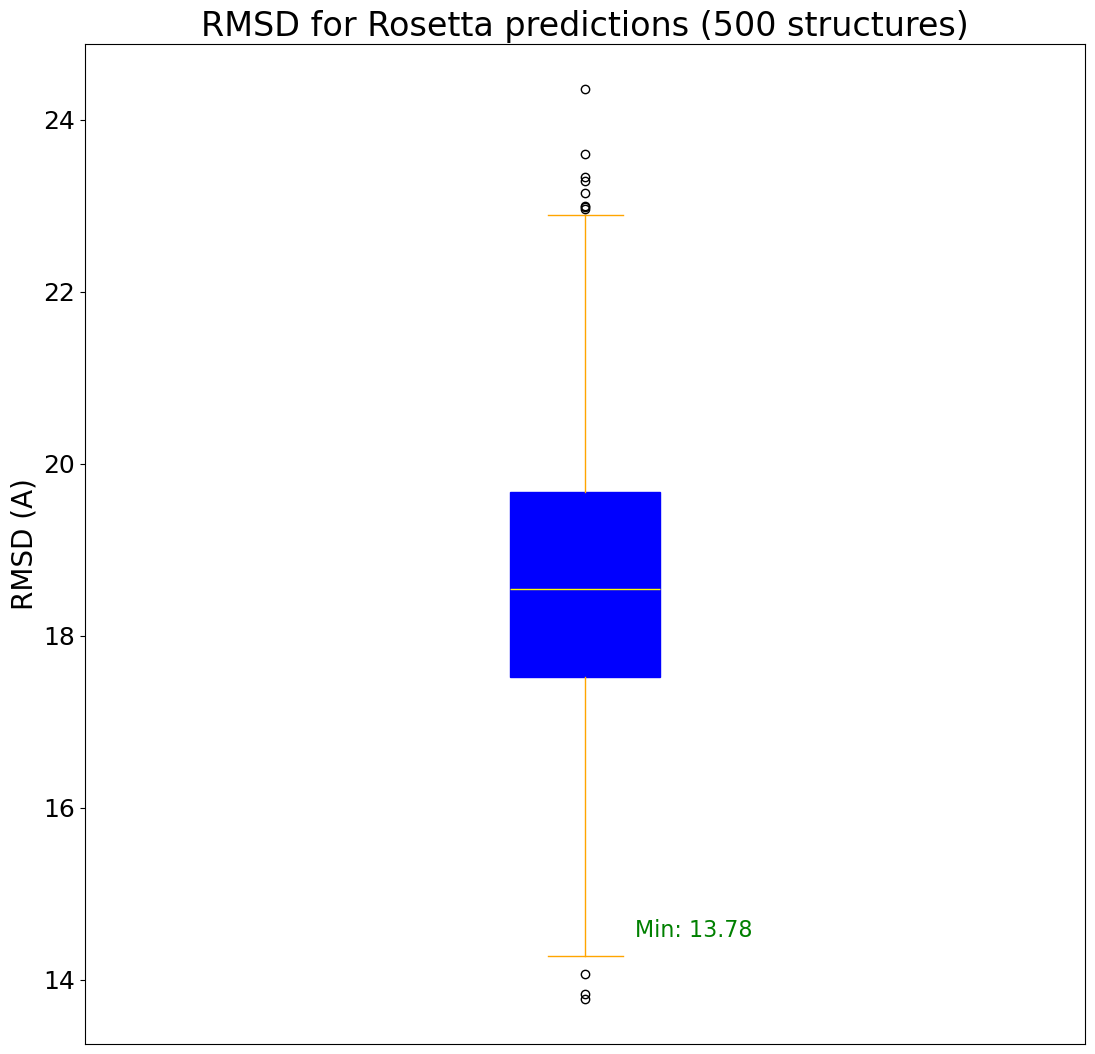

In [7]:
# Make a box-plot with rosetta poses RMSD values
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
ax = plt.axes((0, 0, 1, 1))
ax.text(1.05,14.5, "Min: "+str(round(np.min(resolved_rmsds),2)), fontsize=16, color='green')
bplot=plt.boxplot(resolved_rmsds,patch_artist=True,notch=False)
bplot["boxes"][0].set_color("blue")
bplot["medians"][0].set_color("yellow")
[whisk.set_color("orange") for whisk in bplot["whiskers"]]
[whisk.set_color("orange") for whisk in bplot["caps"]]

plt.title("RMSD for Rosetta predictions (500 structures)",fontsize=24)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.yticks(fontsize=18)
plt.ylabel("RMSD (A)",fontsize=20)
plt.xticks()
#plt.ylim(0,2)

#### Save the pose closest to the crystal structure

In [8]:
min_pose.save_pdb(ROOT_DIR+"/rosetta/crystal_closest.pdb")

In [11]:
best_rosetta=LoadedPDB(ROOT_DIR+"/rosetta/crystal_closest.pdb")

# Align the closest match to the crystal structure and save it
aligned_best_rosetta=align_poses(ref_pose,best_rosetta,silent=True,max_iter=5000)
aligned_best_rosetta.dump_pdb(ROOT_DIR+"/rosetta/crystal_closest_aligned.pdb")
print(get_rmsd(ref_pose,aligned_best_rosetta),"is RMSD for best structure")

13.78064690415585 is RMSD for best structure
